In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import random



import quandl
quandl.read_key()

In [2]:
tab = quandl.get_table('SHARADAR/SEP', ticker = 'AAPL')
date_list = sorted(list(set(tab['date'].tolist())))

In [4]:
day = pd.Timedelta(days=1)
def yesterday(today):
    return date_list[date_list.index(today)-1]

## Tangency portfolio

In [11]:
tickers = []

idx = 0
while(idx < len(date_list)):
    tickers_date = quandl.get_table('SHARADAR/DAILY', date=date_list[idx]).sort_values('marketcap')[-100:].ticker.tolist()
    tickers = list(set(tickers or tickers_date))
    idx += 100
    
tickers = list(set(tickers))

In [5]:
SEP = quandl.get_table('SHARADAR/SEP', ticker = tickers, paginate=True)
DAILY = quandl.get_table('SHARADAR/DAILY', ticker = tickers, paginate=True)

In [18]:
size = 10
window = 220
day = pd.Timedelta(days=1)

start_date = date_list[window]
end_date = date_list[-1]
#end_date = start_date + 1*day

today = start_date

asset = 1
asset_list = [1]

asset_df_index = [today]

while(today <= end_date):
    print(today)
    
    if today in date_list:
        
        today_idx = date_list.index(today)
        
        SEP_today = SEP.loc[SEP.date == today]
        SEP_yesterday = SEP.loc[SEP.date == yesterday(today)]
        DAILY_today = DAILY.loc[DAILY.date == today]
        
        if today > start_date:
            ret = 0
            for idx in range(size):
                today_price = SEP_today[SEP_today.ticker == long_list[idx]].close.values[0]
                yesterday_price = SEP_yesterday[SEP_yesterday.ticker == long_list[idx]].close.values[0]
                ret += long_weight[idx]*today_price/yesterday_price

            asset = ret*asset
            asset_list.append(asset)
            asset_df_index.append(today)
        
        long_list = DAILY_today.sort_values('marketcap')[-size:]['ticker'].tolist()
        
        corr_df = pd.DataFrame({'date': [date_list[idx] for idx in range(today_idx,today_idx-window,-1)]})
        
        for long in long_list:
            input_data = SEP.loc[(date_list[today_idx-window] < SEP.date) & (SEP.date <= date_list[today_idx]) 
                                 & (SEP.ticker == long)].close
            input_data = 1+(input_data.diff(periods=-1)/input_data)
            corr_df[long] = input_data.tolist()
            
        if today == start_date:
            long_weight = [1./size for  stock in long_list]
        
        cov_mat = corr_df.cov().to_numpy()
        cov_mat_inv = np.linalg.inv(cov_mat)
        ret_vec = corr_df.mean().to_numpy()
        id_vec = [1 for elem in ret_vec]
        
        def variance(w):
            return 10000*np.matmul(w,np.matmul(cov_mat,w))
        
        def sharpe(w):
            return np.matmul(w,np.matmul(cov_mat,w))/(np.sum([(ret_vec[i]-1)*w[i] for i in range(len(ret_vec))]))**2
    
        def con1(w):
            return np.sum(w)-1
        def con2(w):
            return np.min(w)
        
        cons = [{'type':'eq', 'fun': con1}, {'type' : 'ineq', 'fun' : con2}]
        

        minimizer = optimize.minimize(sharpe,
                                      long_weight,
                                      tol = 1e-10,
                                      options = {'maxiter' : 1e+2},
                                      bounds = [[0,1] for long in long_weight],
                                      constraints=[{'type':'eq', 'fun': con1},
                                                   {'type' : 'ineq', 'fun' : con2}])
        long_weight = minimizer.x
        long_weight = [0 if x<0.01 else x for x in long_weight]
        long_weight /= np.sum(long_weight)
        
        """A = np.matmul(ret_vec, np.matmul(cov_mat_inv, ret_vec))
        B = np.matmul(ret_vec, np.matmul(cov_mat_inv, id_vec))
        D = np.matmul(id_vec, np.matmul(cov_mat_inv, id_vec))
        
        Omega = [[A,B],[B,D]]
        Omega_inv = np.linalg.inv(Omega)
        
        A2 = Omega_inv[0][0]
        B2 = Omega_inv[0][1]
        D2 = Omega_inv[1][1]
        
        GMV_r = -B2/A2
        opt_r = 1-(D2+2*B2+A2)/(B2+A2)
        
        
        L1, L2 = np.matmul(Omega_inv,[GMV_r, 1])
        
        GMV_weight = L1*np.matmul(cov_mat_inv, ret_vec) + L2*np.matmul(cov_mat_inv, id_vec)
        GMV_weight /= np.sum(GMV_weight)
        
        print('GVM= ', GMV_weight)"""
        
        print(long_list)
        print(long_weight)
        
    today += day

2016-11-15 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'AMZN', 'XOM', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.         0.         0.45165238 0.         0.01299135 0.
 0.53535627 0.         0.         0.        ]
2016-11-16 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'AMZN', 'XOM', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.         0.         0.49289064 0.         0.01785349 0.
 0.48925586 0.         0.         0.        ]
2016-11-17 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'XOM', 'AMZN', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.         0.         0.44091564 0.         0.         0.06499149
 0.49409286 0.         0.         0.        ]
2016-11-18 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'XOM', 'AMZN', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.         0.02129981 0.42263895 0.         0.         0.06880075
 0.48726049 0.         0.         0.        ]
2016-11-19 00:00:00
2016-11-20 00:00:00
2016-11-21 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'XOM', 'AMZN', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.         0.0154367  0.40823299 0.027

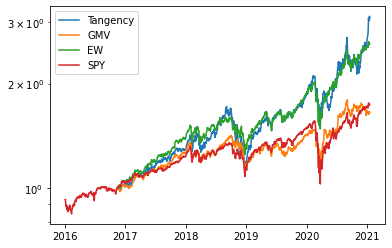

In [21]:
SPY = BMdata[['close']]/BMdata.iloc[-window][['close']]
SPY.index = BMdata.date

asset_df = pd.DataFrame({'asset':asset_list})
asset_df.index = pd.to_datetime(asset_df_index)

GMV_asset_df = pd.DataFrame({'asset':GMV_asset_list})
GMV_asset_df.index = pd.to_datetime(asset_df_index)

EQ_asset_df = pd.DataFrame({'asset':EQ_asset_list})
EQ_asset_df.index = pd.to_datetime(asset_df_index)

plt.plot(asset_df)
plt.plot(GMV_asset_df)
plt.plot(EQ_asset_df)
plt.plot(SPY)
plt.legend(['Tangency', 'GMV', 'EW', 'SPY'])
plt.yscale('log')

In [9]:
BMdata = quandl.get_table('SHARADAR/SFP', ticker = 'SPY')

In [ ]:
SPY = BMdata[['close']]/BMdata.iloc[-window][['close']]
SPY.index = BMdata.date
SPY

## GMV-weighted portfolio

In [11]:
size = 10
window = 220
day = pd.Timedelta(days=1)

start_date = date_list[window]
end_date = date_list[-1]
#end_date = start_date + 1*day

today = start_date

asset = 1
GMV_asset_list = [1]

asset_df_index = [today]

while(today <= end_date):
    print(today)
    
    if today in date_list:
        
        today_idx = date_list.index(today)
        
        SEP_today = SEP.loc[SEP.date == today]
        SEP_yesterday = SEP.loc[SEP.date == yesterday(today)]
        DAILY_today = DAILY.loc[DAILY.date == today]
        
        if today > start_date:
            ret = 0
            for idx in range(size):
                today_price = SEP_today[SEP_today.ticker == long_list[idx]].close.values[0]
                yesterday_price = SEP_yesterday[SEP_yesterday.ticker == long_list[idx]].close.values[0]
                ret += long_weight[idx]*today_price/yesterday_price

            asset = ret*asset
            GMV_asset_list.append(asset)
            asset_df_index.append(today)
        
        long_list = DAILY_today.sort_values('marketcap')[-size:]['ticker'].tolist()
        
        corr_df = pd.DataFrame({'date': [date_list[idx] for idx in range(today_idx,today_idx-window,-1)]})
        
        for long in long_list:
            input_data = SEP.loc[(date_list[today_idx-window] < SEP.date) & (SEP.date <= date_list[today_idx]) 
                                 & (SEP.ticker == long)].close
            input_data = 1+(input_data.diff(periods=-1)/input_data)
            corr_df[long] = input_data.tolist()
            
        if today == start_date:
            long_weight = [1./size for  stock in long_list]
        
        cov_mat = corr_df.cov().to_numpy()
        cov_mat_inv = np.linalg.inv(cov_mat)
        ret_vec = corr_df.mean().to_numpy()
        id_vec = [1 for elem in ret_vec]
        
        def variance(w):
            return 10000*np.matmul(w,np.matmul(cov_mat,w))
        
        def sharpe(w):
            return np.matmul(w,np.matmul(cov_mat,w))/(np.sum([(ret_vec[i]-1)*w[i] for i in range(len(ret_vec))]))**2
    
        def con1(w):
            return np.sum(w)-1
        def con2(w):
            return np.min(w)
        
        cons = [{'type':'eq', 'fun': con1}, {'type' : 'ineq', 'fun' : con2}]
        

        minimizer = optimize.minimize(variance,
                                      long_weight,
                                      bounds = [[0,1] for long in long_weight] ,
                                      constraints=({'type':'eq', 'fun': con1},
                                                   {'type' : 'ineq', 'fun' : con2},))
        long_weight = minimizer.x
        long_weight = [0 if x<0.01 else x for x in long_weight]
        long_weight /= np.sum(long_weight)
        
        """A = np.matmul(ret_vec, np.matmul(cov_mat_inv, ret_vec))
        B = np.matmul(ret_vec, np.matmul(cov_mat_inv, id_vec))
        D = np.matmul(id_vec, np.matmul(cov_mat_inv, id_vec))
        
        Omega = [[A,B],[B,D]]
        Omega_inv = np.linalg.inv(Omega)
        
        A2 = Omega_inv[0][0]
        B2 = Omega_inv[0][1]
        D2 = Omega_inv[1][1]
        
        GMV_r = -B2/A2
        opt_r = 1-(D2+2*B2+A2)/(B2+A2)
        
        
        L1, L2 = np.matmul(Omega_inv,[GMV_r, 1])
        
        GMV_weight = L1*np.matmul(cov_mat_inv, ret_vec) + L2*np.matmul(cov_mat_inv, id_vec)
        GMV_weight /= np.sum(GMV_weight)
        
        print('GVM= ', GMV_weight)"""
        
        print(long_list)
        print(long_weight)
        
    today += day

2016-11-15 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'AMZN', 'XOM', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.         0.         0.54108667 0.         0.         0.07260121
 0.24888487 0.         0.0996821  0.03774514]
2016-11-16 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'AMZN', 'XOM', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.         0.         0.54188174 0.         0.         0.0735221
 0.24582158 0.         0.09863477 0.04013981]
2016-11-17 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'XOM', 'AMZN', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.         0.         0.5350419  0.         0.07472757 0.
 0.24076555 0.         0.09787178 0.0515932 ]
2016-11-18 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'XOM', 'AMZN', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.         0.         0.53059864 0.         0.08328416 0.
 0.23825532 0.         0.10021544 0.04764644]
2016-11-19 00:00:00
2016-11-20 00:00:00
2016-11-21 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'XOM', 'AMZN', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.         0.         0.53390661 0.    

## Equal Weight

In [12]:
size = 10
window = 220
day = pd.Timedelta(days=1)

start_date = date_list[window]
end_date = date_list[-1]
#end_date = start_date + 1*day

today = start_date

asset = 1
EQ_asset_list = [1]

asset_df_index = [today]

while(today <= end_date):
    print(today)
    
    if today in date_list:
        
        today_idx = date_list.index(today)
        
        SEP_today = SEP.loc[SEP.date == today]
        SEP_yesterday = SEP.loc[SEP.date == yesterday(today)]
        DAILY_today = DAILY.loc[DAILY.date == today]
        
        if today > start_date:
            ret = 0
            for idx in range(size):
                today_price = SEP_today[SEP_today.ticker == long_list[idx]].close.values[0]
                yesterday_price = SEP_yesterday[SEP_yesterday.ticker == long_list[idx]].close.values[0]
                ret += long_weight[idx]*today_price/yesterday_price

            asset = ret*asset
            EQ_asset_list.append(asset)
            asset_df_index.append(today)
        
        long_list = DAILY_today.sort_values('marketcap')[-size:]['ticker'].tolist()
        
        corr_df = pd.DataFrame({'date': [date_list[idx] for idx in range(today_idx,today_idx-window,-1)]})
        
        for long in long_list:
            input_data = SEP.loc[(date_list[today_idx-window] < SEP.date) & (SEP.date <= date_list[today_idx]) 
                                 & (SEP.ticker == long)].close
            input_data = 1+(input_data.diff(periods=-1)/input_data)
            corr_df[long] = input_data.tolist()
            
        long_weight = [1./size for  stock in long_list]
        
        """A = np.matmul(ret_vec, np.matmul(cov_mat_inv, ret_vec))
        B = np.matmul(ret_vec, np.matmul(cov_mat_inv, id_vec))
        D = np.matmul(id_vec, np.matmul(cov_mat_inv, id_vec))
        
        Omega = [[A,B],[B,D]]
        Omega_inv = np.linalg.inv(Omega)
        
        A2 = Omega_inv[0][0]
        B2 = Omega_inv[0][1]
        D2 = Omega_inv[1][1]
        
        GMV_r = -B2/A2
        opt_r = 1-(D2+2*B2+A2)/(B2+A2)
        
        
        L1, L2 = np.matmul(Omega_inv,[GMV_r, 1])
        
        GMV_weight = L1*np.matmul(cov_mat_inv, ret_vec) + L2*np.matmul(cov_mat_inv, id_vec)
        GMV_weight /= np.sum(GMV_weight)
        
        print('GVM= ', GMV_weight)"""
        
        print(long_list)
        print(long_weight)
        
    today += day

2016-11-15 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'AMZN', 'XOM', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2016-11-16 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'AMZN', 'XOM', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2016-11-17 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'XOM', 'AMZN', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2016-11-18 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'XOM', 'AMZN', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2016-11-19 00:00:00
2016-11-20 00:00:00
2016-11-21 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'XOM', 'AMZN', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2016-11-22 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'XOM', 'AMZN', 'BRK.B', 'MSFT', 'GOOGL', 'AAPL']
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2016-11-23 00:00:00
['WFC', 'JPM', 'JNJ', 'FB', 'XOM', 'AMZN', 'BRK.B', 